## Table of Contents 
1. Notebook Setup
2. Cleaning
3. Joining **'steamdf'** and **'salesdf'**
4. Cleaning New Dataframe
5. Visualization
6. Exporting Data

### 1. Notebook Setup

In [248]:
# Importing packages
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from pathlib import Path

In [249]:
# Importing Datasets
steamdf = pd.read_csv(Path('Datasets') / 'steam_games.csv')
salesdf = pd.read_csv(Path('Datasets') / 'vgsales.csv')

In [250]:
# Definining a quick shape function 'bigshape' for future reference
def bigshape(x, y):
    bigshape = pd.DataFrame(list(zip(x.shape, y.shape)))\
        .rename(columns= {0: 'left', 1: 'right'})\
        .rename(index= {0: 'rows', 1: 'columns'})
    display(bigshape)
print(bigshape(steamdf, salesdf))

,left,right
rows,40833,16598
columns,20,11


None


In [251]:
# Let's check out our two datasets
print('\\\\ steamdf \\\\')
display(steamdf.head())
print('\\\\ salesdf \\\\')
display(salesdf.head())

\\ steamdf \\


,url,types,name,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,popular_tags,game_details,languages,achievements,genre,game_description,mature_content,minimum_requirements,recommended_requirements,original_price,discount_price
0,https://store.steampowered.com/app/379720/DOOM/,app,DOOM,Now includes all three premium DLC packs (Unto...,"Very Positive,(554),- 89% of the 554 user revi...","Very Positive,(42,550),- 92% of the 42,550 use...","May 12, 2016",id Software,"Bethesda Softworks,Bethesda Softworks","FPS,Gore,Action,Demons,Shooter,First-Person,Gr...","Single-player,Multi-player,Co-op,Steam Achieve...","English,French,Italian,German,Spanish - Spain,...",54.0,Action,"About This Game Developed by id software, the...",NaN,"Minimum:,OS:,Windows 7/8.1/10 (64-bit versions...","Recommended:,OS:,Windows 7/8.1/10 (64-bit vers...",$19.99,$14.99
1,https://store.steampowered.com/app/578080/PLAY...,app,PLAYERUNKNOWN'S BATTLEGROUNDS,PLAYERUNKNOWN'S BATTLEGROUNDS is a battle roya...,"Mixed,(6,214),- 49% of the 6,214 user reviews ...","Mixed,(836,608),- 49% of the 836,608 user revi...","Dec 21, 2017",PUBG Corporation,"PUBG Corporation,PUBG Corporation","Survival,Shooter,Multiplayer,Battle Royale,PvP...","Multi-player,Online Multi-Player,Stats","English,Korean,Simplified Chinese,French,Germa...",37.0,"Action,Adventure,Massively Multiplayer",About This Game PLAYERUNKNOWN'S BATTLEGROUND...,Mature Content Description The developers de...,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$29.99,NaN
2,https://store.steampowered.com/app/637090/BATT...,app,BATTLETECH,Take command of your own mercenary outfit of '...,"Mixed,(166),- 54% of the 166 user reviews in t...","Mostly Positive,(7,030),- 71% of the 7,030 use...","Apr 24, 2018",Harebrained Schemes,"Paradox Interactive,Paradox Interactive","Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...","Single-player,Multi-player,Online Multi-Player...","English,French,German,Russian",128.0,"Action,Adventure,Strategy",About This Game From original BATTLETECH/Mec...,NaN,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$39.99,NaN
3,https://store.steampowered.com/app/221100/DayZ/,app,DayZ,The post-soviet country of Chernarus is struck...,"Mixed,(932),- 57% of the 932 user reviews in t...","Mixed,(167,115),- 61% of the 167,115 user revi...","Dec 13, 2018",Bohemia Interactive,"Bohemia Interactive,Bohemia Interactive","Survival,Zombies,Open World,Multiplayer,PvP,Ma...","Multi-player,Online Multi-Player,Steam Worksho...","English,French,Italian,German,Spanish - Spain,...",NaN,"Action,Adventure,Massively Multiplayer",About This Game The post-soviet country of Ch...,NaN,"Minimum:,OS:,Windows 7/8.1 64-bit,Processor:,I...","Recommended:,OS:,Windows 10 64-bit,Processor:,...",$44.99,NaN
4,https://store.steampowered.com/app/8500/EVE_On...,app,EVE Online,EVE Online is a community-driven spaceship MMO...,"Mixed,(287),- 54% of the 287 user reviews in t...","Mostly Positive,(11,481),- 74% of the 11,481 u...","May 6, 2003",CCP,"CCP,CCP","Space,Massively Multiplayer,Sci-fi,Sandbox,MMO...","Multi-player,Online Multi-Player,MMO,Co-op,Onl...","English,German,Russian,French",NaN,"Action,Free to Play,Massively Multiplayer,RPG,...",About This Game,NaN,"Minimum:,OS:,Windows 7,Processor:,Intel Dual C...","Recommended:,OS:,Windows 10,Processor:,Intel i...",Free,NaN


\\ salesdf \\


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


### 2. Cleaning

In [252]:
# Dropping columns in 'steamdf' that won't be needed in the join
steamdf.drop(columns= ['url', 'types', 'recent_reviews', 'desc_snippet', 'all_reviews', 
                    'achievements', 'languages', 'game_description', 'mature_content', 'original_price', 
                    'discount_price', 'popular_tags', 'game_details', 'minimum_requirements', 'recommended_requirements'], inplace = True)

In [253]:
# We'll be right-joining 'steamdf' into 'salesdf' along the Title column
# This is done to prioritize sales data in 'salesdf'
# But first, we'll reformat column names manually
steamdf = steamdf.rename(columns = {
       'name' : 'Title', 
       'release_date' : 'Release_Date', 
       'developer' : 'Developer', 
       'publisher' : 'Publisher', 
       'genre' : 'Genre'
})
salesdf = salesdf.rename(columns = {'Name' : 'Title'})

In [254]:
# steamdf.Title.values contains symbols and non-English characters (see examples here)
# These can be problematic for joins, especially since they are not found in salesdf.Titles.values
print(steamdf.iloc[13,0])
print(steamdf.iloc[22,0])
print(steamdf.iloc[21433,0])

Call of Duty®: Modern Warfare® Remastered
Team Sonic Racing™
灵魂筹码 Soul at Stake


In [255]:
# For example: the registered trademark symbol ®
# '®' is found in 'steamdf'
steamdf.Title[steamdf.Title.str.contains('®', na= False, )]

13               Call of Duty®: Modern Warfare® Remastered
20                                Call of Duty®: Black Ops
47                     Dishonored®: Death of the Outsider™
62                            The Elder Scrolls®: Legends™
73                                        Castle Crashers®
                               ...                        
40776    Rocksmith® 2014 Edition – Remastered – Cyndi L...
40817    Rocksmith® 2014 Edition – Remastered – Cyndi L...
40827    Rocksmith® 2014 Edition – Remastered – Sabaton...
40828    Rocksmith® 2014 Edition – Remastered – Sabaton...
40829    Rocksmith® 2014 Edition – Remastered – Stone T...
Name: Title, Length: 1497, dtype: object

In [256]:
# '®' is not found in 'salesdf'
salesdf.Title[salesdf.Title.str.contains('®', na= False, )]

Series([], Name: Title, dtype: object)

In [257]:
# There are currently this many titles shared between 'steamdf' and 'salesdf'
print('titles shared between datasets: '+ str(salesdf.Title[salesdf.Title.isin(steamdf.Title)].count())) # 858
print('percentage of total:            ' + str(((salesdf.Title[salesdf.Title.isin(steamdf.Title)].count()) / len(salesdf))*100)) # 5.2%

titles shared between datasets: 858
percentage of total:            5.169297505723581


In [258]:
# Begin standardizing df.Title.values
# Regex to remove special characters exclusive to steamdf.Titles.values
steamdf['Title'] = steamdf['Title'].apply(lambda x: re.sub(r"[^a-zA-Z0-9À-ÿ:\-'\s\!\.\/\?\(\)\&\,°#\*;+·@~¡α\[\]\$♪]", '', str(x)))
salesdf['Title'] = salesdf['Title'].apply(lambda x: re.sub(r"[^a-zA-Z0-9À-ÿ:\-'\s\!\.\/\?\(\)\&\,°#\*;+·@~¡α\[\]\$♪]", '', str(x)))

In [259]:
# Stripping white space from string ends
steamdf['Title'] = steamdf.Title.str.strip()
salesdf['Title'] = salesdf.Title.str.strip()

In [260]:
# Checkpoint: All set with regex
print(steamdf.iloc[13,0])
print(steamdf.iloc[22,0])
print(steamdf.iloc[21433,0])

Call of Duty: Modern Warfare Remastered
Team Sonic Racing
Soul at Stake


In [261]:
# Further standardization of strings with titlecase
steamdf['Title'] = steamdf.Title.str.title()
salesdf['Title'] = salesdf.Title.str.title()

In [262]:
# After running those numbers again:
print('titles shared between datasets: '+ str(salesdf.Title[salesdf.Title.isin(steamdf.Title)].count())) # 1388 
print('percentage of total:            ' + str(((salesdf.Title[salesdf.Title.isin(steamdf.Title)].count()) / len(salesdf))*100)) # 8.36%

titles shared between datasets: 1388
percentage of total:            8.362453307627424


In [263]:
# Next, standardizing steamdf.Release_Date & salesdf.Year values in YYYY format
# The current variety of values in steamdf.Release_Date needs some attention
# Just a few examples:
steamdf.iloc[[20, 9636, 36363, 37363, 38605, 38902, 39190, 39446, 40156, 40527], steamdf.columns.get_loc('Release_Date')]

20                         Nov 9, 2010
9636                               NaN
36363                   When it's done
37363                      Coming soon
38605                              TBA
38902                      COMING 2019
39190                              TBD
39446    TBA - Join our Community Hub!
40156                         Sep 2019
40527                       Early 2019
Name: Release_Date, dtype: object

In [264]:
# We can extract the end-of-string YYYY values with regex
# Then assign the results to a new column: game.Year
steamdf['Release_Year'] = steamdf.Release_Date.str.extract(r".+(\d{4}$)", expand= True)

### 3. Joining **'steamdf'** and **'salesdf'**

In [265]:
# Performing a right join from 'steamdf' to 'salesdf'
# We want the sales data in the salesdf dataset
globalsalesdf = pd.merge(left= steamdf, right= salesdf, how= 'right', left_on= 'Title', right_on= 'Title')

In [266]:
# The high NaN count in columns from 'steamdf' is a testament to the overlap of the datasets
# i.e. not an incredibly strong overlap
def nanpct(x) :
    globalsalesdfnan = x.isna().sum()
    globalsalesdfnanpct = round(x.isna().sum() / len(x) * 100, 1)
    display(pd.DataFrame(pd.concat((globalsalesdfnan, globalsalesdfnanpct), axis = 1).rename(columns= {0: 'NaNs', 1: '#total'})))

nanpct(globalsalesdf)

,NaNs,#total
Title,0,0.0
Release_Date,15226,91.7
Developer,15222,91.7
Publisher_x,15216,91.6
Genre_x,15227,91.7
Release_Year,15229,91.7
Rank,0,0.0
Platform,0,0.0
Year,271,1.6
Genre_y,0,0.0


In [267]:
# Next, we'll address missing Year values in globalsalesdf
# These NaNs originated in 'salesdf'
# Note: Numbers do not include 'Unknown' in Publisher column. More on that later.
salesdf.isna().sum()

Rank              0
Title             0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [268]:
# Fillna to compile YYYYs in globalsalesdf.Year
globalsalesdf.Year.fillna(globalsalesdf.Release_Year, inplace= True)

In [269]:
# This corrected 33 values in our merged dataset
salesdf.Year.isna().sum() - globalsalesdf.Year.isna().sum()

33

In [270]:
# Our next goal: use Publisher_x to correct problem values in Publisher_y
# Just a few pertinent samples:
globalsalesdf.iloc[[4648, 5626, 8845, 9798, 14410, 16559], \
              [1,globalsalesdf.columns.get_loc('Publisher_x'), globalsalesdf.columns.get_loc('Publisher_y')]]

,Release_Date,Publisher_x,Publisher_y
4648,NaN,NaN,Konami Digital Entertainment
5626,"Jun 30, 2010","Activision,Activision",Unknown
8845,"May 16, 2011","Re-Logic,Re-Logic",Unknown
9798,"Jun 1, 2010","SEGA,SEGA",Sega
14410,"Oct 27, 2011","Bohemia Interactive,Bohemia Interactive",Unknown
16559,"May 8, 2014","Focus Home Interactive,Focus Home Interactive",NaN


In [271]:
# First, replace 'Unknown' with np.NaN
globalsalesdf.Publisher_y.replace('Unknown', np.NaN, inplace= True)

In [272]:
# Next, fill NaNs in Publisher_y with values from Publisher_x
globalsalesdf.Publisher_y.fillna(globalsalesdf.Publisher_x, inplace= True)

In [273]:
# Removing duplicates from our newly-formatted Publisher-y column
# We can use split, expand it, and select the first column with .get(0) 
# Then we'll reassign it to Publisher_y
globalsalesdf['Publisher_y'] = globalsalesdf.Publisher_y.str.split(',', expand = True).get(0)

In [274]:
# Samples are looking much better
globalsalesdf.iloc[[4648, 5626, 8845, 9798, 14410, 16559], \
              [1,globalsalesdf.columns.get_loc('Publisher_x'), globalsalesdf.columns.get_loc('Publisher_y')]]

,Release_Date,Publisher_x,Publisher_y
4648,NaN,NaN,Konami Digital Entertainment
5626,"Jun 30, 2010","Activision,Activision",Activision
8845,"May 16, 2011","Re-Logic,Re-Logic",Re-Logic
9798,"Jun 1, 2010","SEGA,SEGA",Sega
14410,"Oct 27, 2011","Bohemia Interactive,Bohemia Interactive",Bohemia Interactive
16559,"May 8, 2014","Focus Home Interactive,Focus Home Interactive",Focus Home Interactive


In [275]:
# Checkpoint: what's the status of our NaNs?
nanpct(globalsalesdf)

,NaNs,#total
Title,0,0.0
Release_Date,15226,91.7
Developer,15222,91.7
Publisher_x,15216,91.6
Genre_x,15227,91.7
Release_Year,15229,91.7
Rank,0,0.0
Platform,0,0.0
Year,238,1.4
Genre_y,0,0.0


In [276]:
# Again, not an incredibly strong overlap, but remember:
# Our original column was full of "Unknown" values as well as NaNs
print('original # of Unknowns: ' + str(len(salesdf[salesdf['Publisher'] == 'Unknown'])))
print('original # of NaN       ' + str(len(salesdf[salesdf['Publisher'].isna()])))
print('total:                = ' + str((len(salesdf[salesdf['Publisher'].isna()])) + \
                                        len(salesdf[salesdf['Publisher'] == 'Unknown'])))
print('current # of Unknowns:  ' + str(len(globalsalesdf[globalsalesdf['Publisher_y'] == 'Unknown'])))
print('current # of NaNs:      ' + str(len(globalsalesdf[globalsalesdf['Publisher_y'].isna()])))
print('total:                = ' + str((len(globalsalesdf[globalsalesdf['Publisher_y'].isna()])) + \
                                        len(globalsalesdf[globalsalesdf['Publisher_y'] == 'Unknown'])))

original # of Unknowns: 203
original # of NaN       58
total:                = 261
current # of Unknowns:  0
current # of NaNs:      236
total:                = 236


### 4. Cleaning New Dataframe

In [277]:
# First, drop redundant and irrelevant columns
globalsalesdf.drop(columns = ['Release_Date', 'Developer', 'Release_Year', 'Publisher_x', 'Genre_x'], inplace= True)


In [278]:
# Then rename duplicate columns from the join
globalsalesdf = globalsalesdf.rename(columns = {'Genre_y' : 'Genre', 'Publisher_y' : 'Publisher'})

In [279]:
# Reorder columns for readability
globalsalesdf = globalsalesdf[['Title', 'Rank', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]

In [280]:
# Rename game platforms for colloqial familiarity
globalsalesdf.replace({'Platform' : {
    'Wii' : 'Nintendo Wii',
    'NES' : 'Nintendo NES',
    'GB' : 'Game Boy', 
    'DS' : 'Nintendo DS',
    'X360' : 'Xbox 360', 
    'GEN' : 'Sega Genesis',
    'PS3' : 'PlayStation 3',
    'PS2' : 'PlayStation 2',
    'SNES' : 'Super Nintendo',
    'GBA' : 'Game Boy Advance',
    '3DS' : 'Nintendo 3DS',
    'PS4' : 'PlayStation 4',
    'N64': 'Nintendo 64',
    'PS' : 'PlayStation',
    'XB' : 'Xbox',
    '2600' : 'Atari 2600',
    'PSP' : 'Sony PSP',
    'XOne' : 'Xbox One',
    'GC' : 'GameCube',
    'WiiU' : 'Nintendo WiiU',
    'DC' : 'Dreamcast',
    'PSV' : 'PlayStation Vita',
    'SAT' : 'Sega Saturn',
    'SCD' : 'Sega CD',
    'WS' : 'WonderSwan',
    'NG' : 'Neo Geo',
    'TG16' : 'TurboGrafx-16',
    'GG' : 'Game Gear',
    'PCFX' : 'PC-FX'},
    'Genre' : {'Platform' : 'Platformer'} # And also correct this Genre value
}, inplace = True)

In [281]:
# Use melt to reshape Region/Sales values 
globalsalesdf = globalsalesdf.melt(['Title', 'Rank', 'Platform', 'Year', 'Genre', 'Publisher'], var_name= 'Region', value_name= 'Sales')

### 5. Visualization

Text(0.5, 1.0, 'Countplot of Platforms')

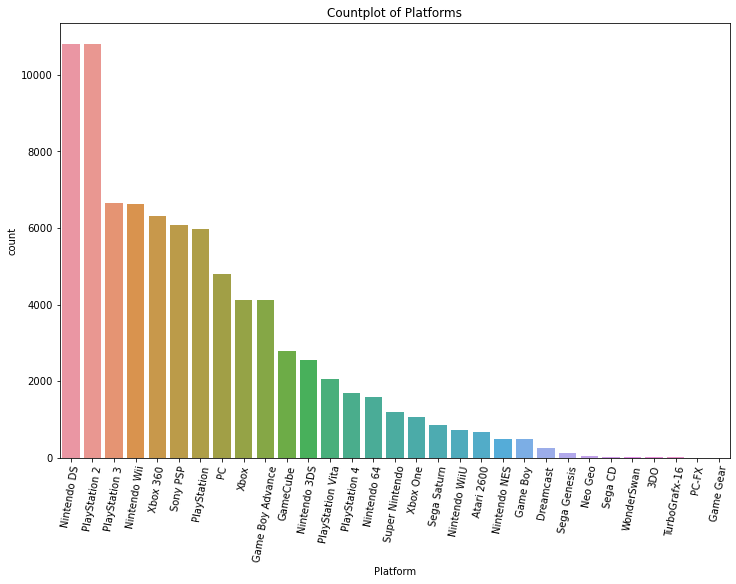

In [282]:
# Using seaborn to create a countplot so that we can double check our future Tableau work
plt.figure(figsize=(12,8))
ax = sns.countplot(x= 'Platform', 
                    data=globalsalesdf,
                    order = globalsalesdf['Platform'].value_counts().index
                    )
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
plt.title('Countplot of Platforms')

### 6. Exporting Data

In [283]:
# Here's a look at our final 'globalsalesdf' dataframe
globalsalesdf.head()

,Title,Rank,Platform,Year,Genre,Publisher,Region,Sales
0,Wii Sports,1,Nintendo Wii,2006.0,Sports,Nintendo,NA_Sales,41.49
1,Super Mario Bros.,2,Nintendo NES,1985.0,Platformer,Nintendo,NA_Sales,29.08
2,Mario Kart Wii,3,Nintendo Wii,2008.0,Racing,Nintendo,NA_Sales,15.85
3,Wii Sports Resort,4,Nintendo Wii,2009.0,Sports,Nintendo,NA_Sales,15.75
4,Pokemon Red/Pokemon Blue,5,Game Boy,1996.0,Role-Playing,Nintendo,NA_Sales,11.27


In [284]:
# Using nanpct to compare final NaN counts
print('\\\\ steamdf \\\\')
display(nanpct(steamdf))
print('\\\\ salesdf \\\\')
display(nanpct(salesdf))
print('\\\\ globalsalesdf\\\\')
display(nanpct(globalsalesdf))

\\ steamdf \\


,NaNs,#total
Title,0,0.0
Release_Date,3179,7.8
Developer,343,0.8
Publisher,5100,12.5
Genre,438,1.1
Release_Year,4133,10.1


None

\\ salesdf \\


,NaNs,#total
Rank,0,0.0
Title,0,0.0
Platform,0,0.0
Year,271,1.6
Genre,0,0.0
Publisher,58,0.3
NA_Sales,0,0.0
EU_Sales,0,0.0
JP_Sales,0,0.0
Other_Sales,0,0.0


None

\\ globalsalesdf\\


,NaNs,#total
Title,0,0.0
Rank,0,0.0
Platform,0,0.0
Year,1190,1.4
Genre,0,0.0
Publisher,1180,1.4
Region,0,0.0
Sales,0,0.0


None

In [285]:
# And one last bigshape measurement
bigshape(globalsalesdf, salesdf)

,left,right
rows,83020,16598
columns,8,11


In [286]:
# The globalsalesdf dataframe is now ready for export
globalsalesdf.to_csv(Path('Tableau Inputs') / 'TopGames_GlobalSalesdf.csv')